In [1]:
import os
import shutil
import matplotlib.pyplot as plt
from utils import sparse_crossentropy_ignoring_last_label, \
    Jaccard, sparse_accuracy_ignoring_last_label, \
    get_VOC2012_classes, workers, SegModel, build_callbacks
from tensorflow.keras.optimizers import Adam
from glob import glob
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [6]:
PATH = '/content/data/OpenSourceDatasets/VOCdevkit/VOC2012'
impath = 'JPEGImages'
gtpath = 'SegmentationClass'
###Build the training dataset

gtfiles = [os.path.splitext(os.path.basename(f))[0] \
           for f in glob(os.path.join(PATH,gtpath,'*'))]
imfiles = [f for f in glob(os.path.join(PATH,impath,'*')) \
           if os.path.splitext(os.path.basename(f))[0] in gtfiles]

for f in imfiles:
    dest = os.path.join(PATH, impath, 'train', os.path.basename(f))
    if not os.path.exists(os.path.join(PATH,impath,'train')):
        os.makedirs(os.path.join(PATH,impath,'train'))
    shutil.copy(f, dest)

image_size = (512, 512) #(512,512) (720, 1280)

better_model = False
load_pretrained_weights = True

losses = sparse_crossentropy_ignoring_last_label
metrics = {'pred_mask' : [Jaccard, sparse_accuracy_ignoring_last_label]}

backbone = 'mobilenetv2' #mobilenetv2, xception

NET = 'deeplab_' + backbone
#PATH = '/content/data/freiburg_forest_annotated/processed/'
PATH = '/content/data/OpenSourceDatasets/VOCdevkit/VOC2012'
impath = 'JPEGImages/train'
gtpath = 'SegmentationClass'
n_classes = len(get_VOC2012_classes()) - 1
epochs = 10
bs =12 
#n_classes = 5

print('Num workers:', workers)
print('Backbone:', backbone)
print('Path to dataset:', PATH)
print('N classes:', n_classes)
print('Image size:', image_size)
print('Batch size:', bs)


SegClass = SegModel(dataset=PATH, impath=impath, \
                    gtpath=gtpath, image_size=image_size)
SegClass.set_batch_size(bs)
SegClass.set_num_epochs(epochs)
print(SegClass.batch_size, SegClass.epochs)

Num workers: 3
Backbone: mobilenetv2
Path to dataset: /content/data/OpenSourceDatasets/VOCdevkit/VOC2012
N classes: 21
Image size: (512, 512)
Batch size: 12
12 10


## DeepLab V3+ And a SubPixel Upsampling Layer (better model) or Original

In [7]:
if better_model:
    model = SegClass.create_seg_model(net='subpixel',n=n_classes, \
                                      load_weights=load_pretrained_weights, \
                                      multi_gpu=False, backbone=backbone)
else:
    model = SegClass.create_seg_model(net='original',n=n_classes, \
                                      load_weights=load_pretrained_weights, \
                                      multi_gpu=False, backbone=backbone)

model.summary()    

Model: "deeplabv3p"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 512, 512, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 256, 256, 32) 864         lambda_5[0][0]                   
__________________________________________________________________________________________________
Conv_BN (BatchNormalization)    (None, 256, 256, 32) 128         Conv[0][0]                       
_________________________________________________________________________________________

### Train with generator

In [9]:
train_generator = SegClass.create_generators(blur=5,crop_shape=None, mode='train', n_classes=n_classes,\
                                             horizontal_flip=True, vertical_flip=False, brightness=0.3,\
                                             rotation=False, zoom=0.1, validation_split=.15, seed=7, \
                                             do_ahisteq=False)
valid_generator = SegClass.create_generators(blur=0, crop_shape=None, mode='validation', \
                                             n_classes=n_classes, horizontal_flip=True, \
                                             vertical_flip=False, brightness=.1, rotation=False, \
                                             zoom=.05, validation_split=.15, seed=7, do_ahisteq=False)

In [10]:
monitor = 'Jaccard'
mode = 'max'
log_dir = '/content/python/logs'
callbacks = build_callbacks(network_name=SegClass.net,\
                            network_path=SegClass.modelpath,\
                            monitor=monitor, mode=mode, \
                            tf_board=False, log_dir=log_dir)
 
# fine-tune model (train only last conv layers)
if load_pretrained_weights:
    flag = 0
    for k, l in enumerate(model.layers):
        l.trainable = False
        if l.name == 'concat_projection':
            flag = 1
        if flag:
            l.trainable = True

print('Weights path:', SegClass.modelpath)       
       
model.compile(optimizer = Adam(lr=7e-4, epsilon=1e-8, decay=1e-6), \
              sample_weight_mode = "temporal",\
              loss = losses, metrics = metrics)

history = SegClass.train_generator(model, train_generator, valid_generator,\
                                   callbacks, mp = True)

Weights path: weights/mobilenetv2_original.h5
Epoch 1/10
 40/206 [====>.........................] - ETA: 3:18 - loss: 0.1629 - Jaccard: 0.6670 - sparse_accuracy_ignoring_last_label: 0.9630

IndexError: arrays used as indices must be of integer (or boolean) type

### Compare Models

In [4]:
# Load original deeplab and subpixel-deeplab
model1 = SegClass.create_seg_model(net='original',n=n_classes, load_weights=False, multi_gpu=False, backbone=backbone)
model1.load_weights('weights/mobilenetv2_original.h5')
model2 = SegClass.create_seg_model(net='subpixel',n=n_classes, load_weights=False, multi_gpu=False, backbone=backbone)
model2.load_weights('weights/mobilenetv2_subpixel.h5')

ValueError: Dimension 0 in both shapes must be equal, but are 1 and 6 for 'Assign_542' (op: 'Assign') with input shapes: [1,1,256,21], [6,256,1,1].

In [6]:
def mIOU(gt, preds):
    ulabels = np.unique(gt)
    iou = np.zeros(len(ulabels))
    for k, u in enumerate(ulabels):
        inter = (gt == u) & (preds==u)
        union = (gt == u) | (preds==u)
        iou[k] = inter.sum()/union.sum()
    return np.round(iou.mean(), 2)

Text(0.5,1,'Subpixel DeepLab + CRF\nmIOU: 0.61')

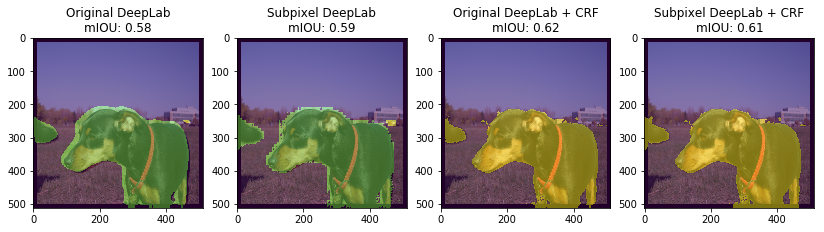

In [7]:
i = np.random.randint(0, len(valid_generator))
x,y,s = valid_generator.__getitem__(i)
preds1 = np.argmax(model1.predict(x), -1)[0].reshape(image_size)
preds2 = np.argmax(model2.predict(x), -1)[0].reshape(image_size)

im = x[0].astype('uint8')
gt = y[0].reshape(image_size).astype('int32')

plt.figure(figsize=(14,10))
plt.subplot(141)
plt.imshow(x[0].astype('uint8'))
plt.imshow(preds1, alpha=.5)
plt.title('Original DeepLab\nmIOU: '+str(mIOU(gt, preds1)))
plt.subplot(142)
plt.imshow(x[0].astype('uint8'))
plt.imshow(preds2, alpha=.5)
plt.title('Subpixel DeepLab\nmIOU: '+str(mIOU(gt, preds2)))
plt.subplot(143)
MAP = do_crf(im, preds1, zero_unsure=False)
plt.imshow(x[0].astype('uint8'))
plt.imshow(MAP, alpha=.5)
plt.title('Original DeepLab + CRF\nmIOU: '+str(mIOU(gt, MAP)))
plt.subplot(144)
MAP = do_crf(im, preds2, zero_unsure=False)
plt.imshow(x[0].astype('uint8'))
plt.imshow(MAP, alpha=.5)
plt.title('Subpixel DeepLab + CRF\nmIOU: '+str(mIOU(gt, MAP)))

In [8]:
def calculate_iou(model, nb_classes = 21):
    SegClass.set_batch_size(1)
    valid_generator = SegClass.create_generators(crop_shape = None,mode = 'validation', n_classes = nb_classes, 
                                                 horizontal_flip = False, vertical_flip = False,
                                                 brightness=0, rotation=False,
                                                 zoom=0, validation_split = .05, seed = 7, do_ahisteq = False)
    label = np.zeros((len(valid_generator),np.prod(image_size)), dtype='float32')
    X = np.zeros((len(valid_generator), image_size[0], image_size[1], 3), dtype='float32')
    for n in range(len(valid_generator)):
        x,y,_ = valid_generator.__getitem__(n)
        label[n,:] = y[0,:,0]
        X[n,:,:,:] = x
    preds = model.predict(X, batch_size=1)
    conf_m = np.zeros((nb_classes, nb_classes), dtype=float)
    total = 0
    mask = np.reshape(np.argmax(preds, axis=-1), (-1,) + image_size)
    flat_pred = np.ravel(mask).astype('int')
    flat_label = np.ravel(label).astype('int')
    for p, l in zip(flat_pred, flat_label):
        if l == nb_classes:
            continue
        if l < nb_classes and p < nb_classes:
            conf_m[l-1, p-1] += 1
        else:
            print('Invalid entry encountered, skipping! Label: ', l,
                    ' Prediction: ', p, ' Img_num: ', img_num)
    I = np.diag(conf_m)
    U = np.sum(conf_m, axis=0) + np.sum(conf_m, axis=1) - I
    IOU = I/U
    meanIOU = np.mean(IOU)
    return conf_m
conf_1 = calculate_iou(model1, nb_classes = 21)
conf_2 = calculate_iou(model2, nb_classes = 21)

Text(0.5,1,'Subpixel DeepLab\nMean IOU: 0.92')

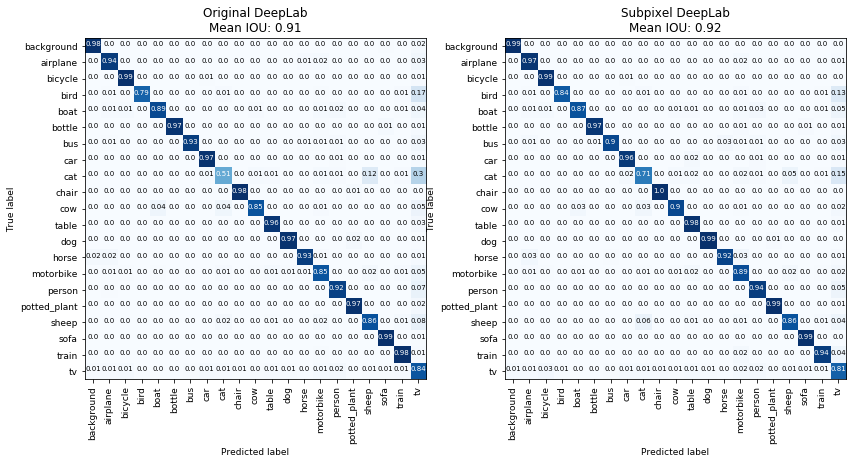

In [38]:
classes = [c for c in get_VOC2012_classes().values()][:-1]
plt.figure(figsize=(12,8))
plt.subplot(121)
cm1=plot_confusion_matrix(conf_1, classes, normalize=True)
plt.title('Original DeepLab\nMean IOU: '+ str(np.round(np.diag(cm1).mean(), 2)))
plt.subplot(122)
cm2=plot_confusion_matrix(conf_2, classes, normalize=True)
plt.title('Subpixel DeepLab\nMean IOU: '+ str(np.round(np.diag(cm2).mean(), 2)))